# Web Crawiling project (2)

- 유튜브 랭킹 사이트 이용

    - https://youtube-rank.com/board/bbs/board.php?bo_table=youtube

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from urllib.error import HTTPError
from urllib.error import URLError
from selenium.common.exceptions import NoSuchElementException
import numpy as np
import pandas as pd
import time

from bs4 import BeautifulSoup

In [2]:
url = 'https://youtube-rank.com/board/bbs/board.php?bo_table=youtube'

- rank, title, category, subscriber, view, video 정보를 가져와서 저장
    - rank: table td.rank
    - title: table td.subject h1 a
    - category: table td.subject p.category
    - subscriber: table td.subscriber_cnt
    - view: table td.view_cnt
    - video: table td.video_cnt

- 광고
    - div#ad_positon_box div#dismiss-button click 필요 -> 있을 때 있고 없을 때 있음

- 페이지 이동
    - nav.pg_wrap a -> for문으로 페이지 넘기기

In [3]:
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
driver.get(url)

In [4]:
# 페이지 정보 가져오기
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

In [5]:
# rank 정보 가져오기
rank_no = soup.select('table td.rank')
print(len(rank_no), rank_no[0].text)

100 
                        1                    


In [6]:
# title 정보 불러오기
channel_title = soup.select('table td.subject h1 a')
print(len(channel_title), channel_title[1].text.strip())

100 BANGTANTV


In [7]:
# category 정보 불러오기
category_name = soup.select('table td.subject p.category')
print(len(category_name), category_name[0].text)

100 [음악/댄스/가수]
                                
                                


In [8]:
# subscriber 정보 불러오기
subscriber_cnt = soup.select('table td.subscriber_cnt')
print(len(subscriber_cnt), subscriber_cnt[0].text)

100 8960만


In [9]:
# view 정보 불러오기
view_cnt = driver.find_elements(By.CSS_SELECTOR, 'table td.view_cnt')
print(len(view_cnt), view_cnt[0].text)

100 319억6888만


In [10]:
# video 정보 불러오기
video_cnt = driver.find_elements(By.CSS_SELECTOR, 'table td.video_cnt')
print(len(video_cnt), video_cnt[0].text)

100 535개


In [11]:
# 페이지별 URL 만들기
page = 1
url = f'https://youtube-rank.com/board/bbs/board.php?bo_table=youtube&page={page}'

In [12]:
driver.close()

In [13]:
# 반복문을 이용한 크롤링
result = []

driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))

for i in range(1, 11):
    url = f'https://youtube-rank.com/board/bbs/board.php?bo_table=youtube&page={i}'
    driver.get(url)
    time.sleep(2)
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.select('form table tbody tr')
    for channel in table:
        rank_no = channel.select('td')[0].text.strip()
        channel_title = channel.select('h1 a')[0].text.strip()
        category_name = channel.select('p.category')[0].text.strip()
        subscriber_cnt = channel.select('td.subscriber_cnt')[0].text
        view_cnt = channel.select('td.view_cnt')[0].text
        video_cnt = channel.select('td.video_cnt')[0].text
        data = [rank_no, channel_title, category_name, subscriber_cnt, view_cnt, video_cnt]
        result.append(data)

driver.close()

In [14]:
# DataFrame 생성

df = pd.DataFrame(result, columns=['rank', 'title', 'category', 'subscriber', 'view', 'video'])
df.head()
df.to_csv('./crawling/youtube_ranking.csv', index=False)

In [15]:
import matplotlib.pyplot as plt

In [16]:
df.head()

,rank,title,category,subscriber,view,video
0,1,BLACKPINK,[음악/댄스/가수],8960만,319억6888만,535개
1,2,BANGTANTV,[음악/댄스/가수],7550만,207억5326만,"2,249개"
2,3,HYBE LABELS,[음악/댄스/가수],7100만,284억5091만,"1,306개"
3,4,SMTOWN,[음악/댄스/가수],3180만,272억6233만,"4,143개"
4,5,JYP Entertainment,[음악/댄스/가수],2730만,197억7223만,"1,719개"


In [17]:
# 수치형으로 변경

df['subscriber'] = df['subscriber'].replace('만', '0000', regex=True).astype('int64')
df['view'] = df['view'].replace({'억':'', '만':'0000'}, regex=True).astype('int64')
df['video'] = df['video'].replace({'개':'', ',':''}, regex=True).astype('int64')
df.head()

,rank,title,category,subscriber,view,video
0,1,BLACKPINK,[음악/댄스/가수],89600000,31968880000,535
1,2,BANGTANTV,[음악/댄스/가수],75500000,20753260000,2249
2,3,HYBE LABELS,[음악/댄스/가수],71000000,28450910000,1306
3,4,SMTOWN,[음악/댄스/가수],31800000,27262330000,4143
4,5,JYP Entertainment,[음악/댄스/가수],27300000,19772230000,1719


In [18]:
# pivot 테이블 생성
pivot_df = df.pivot_table(index='category', values='subscriber', aggfunc=['sum', 'count'])
pivot_df.head()

,sum,count
,subscriber,subscriber
category,,
[BJ/인물/연예인],100890000,58
[IT/기술/컴퓨터],10050000,7
[TV/방송],270300000,122
[게임],68390000,51
[교육/강의],27910000,19


In [19]:
pivot_df.columns = ['subscriber_sum', 'category_count']
pivot_df.head()

,subscriber_sum,category_count
category,,
[BJ/인물/연예인],100890000,58
[IT/기술/컴퓨터],10050000,7
[TV/방송],270300000,122
[게임],68390000,51
[교육/강의],27910000,19


In [20]:
pivot_df = pivot_df.reset_index()
pivot_df.head()

,category,subscriber_sum,category_count
0,[BJ/인물/연예인],100890000,58
1,[IT/기술/컴퓨터],10050000,7
2,[TV/방송],270300000,122
3,[게임],68390000,51
4,[교육/강의],27910000,19


In [21]:
pivot_df = pivot_df.sort_values(by='subscriber_sum', ascending=False)
pivot_df.head()

,category,subscriber_sum,category_count
12,[음악/댄스/가수],828840000,153
16,[키즈/어린이],405120000,130
7,[미분류],315960000,195
2,[TV/방송],270300000,122
11,[음식/요리/레시피],217610000,71


In [22]:
# 그래프에 한글 작성

from matplotlib import font_manager, rc
import platform
if platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname = path).get_name()
    rc('font', family = font_name)
elif platform.system() == 'Darwin':
    rc('font', family = 'AppleGothic')
else:
    print('Check your OS system')

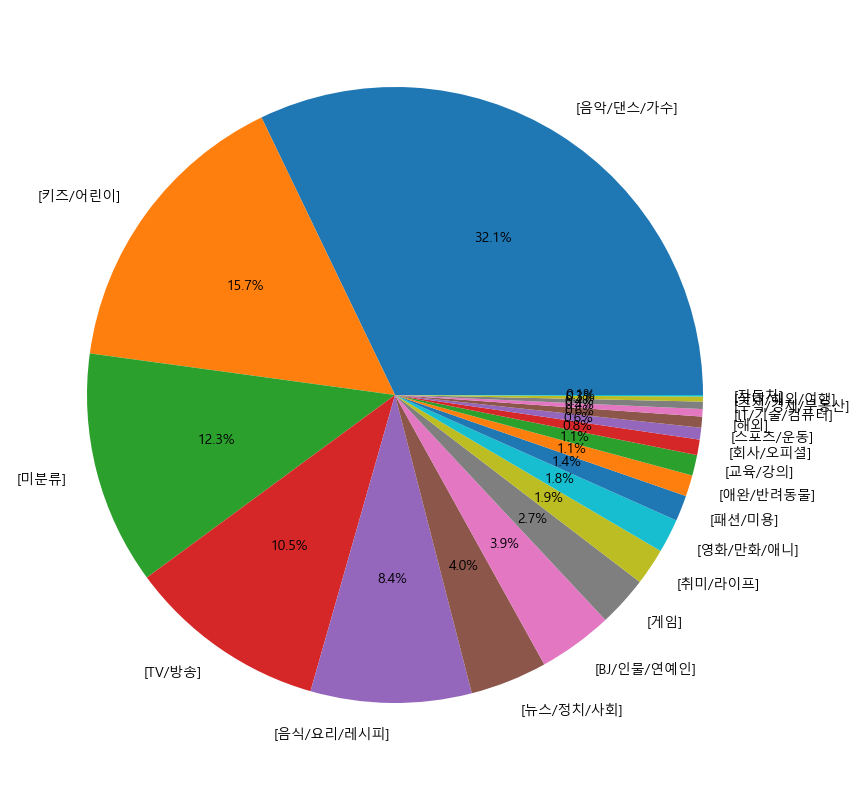

In [23]:
# 카테고리별 구독자수 시각화
plt.figure(figsize = (30, 10))
plt.pie(pivot_df['subscriber_sum'], labels=pivot_df['category'], autopct='%1.1f%%')
plt.show()

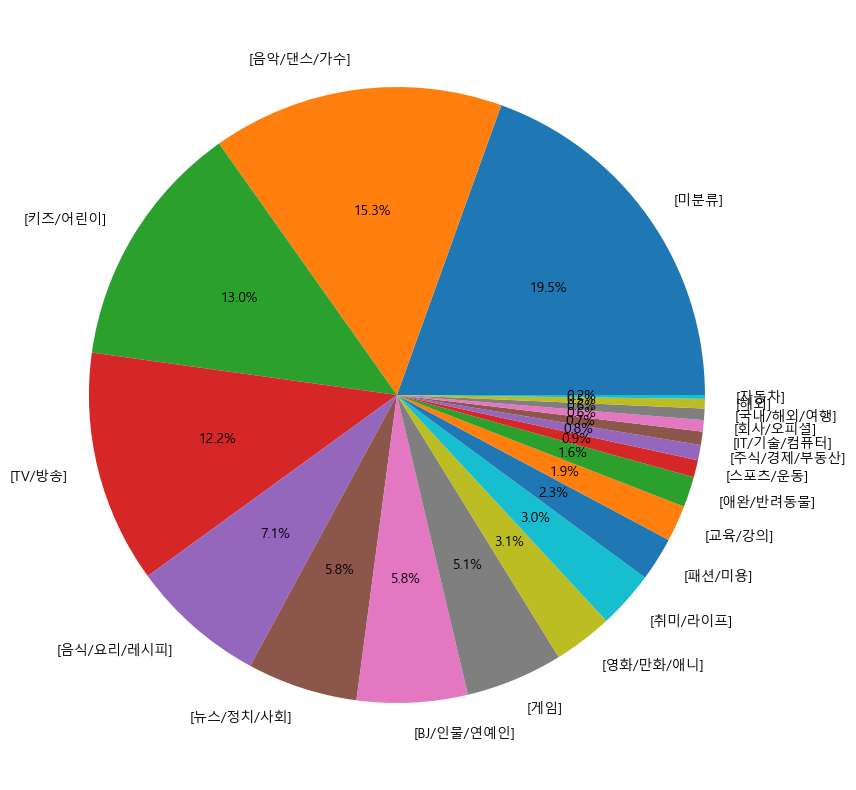

In [25]:
# 카테고리별 채널 수 시각화
pivot_df=pivot_df.sort_values(by='category_count', ascending=False)
plt.figure(figsize = (30, 10))
plt.pie(pivot_df['category_count'], labels=pivot_df['category'], autopct='%1.1f%%')
plt.show()